# Оценка эффективности
## 2 лабораторная работа - моделирование работы ПТУРа Milan против Т-80

В данной работе приводятся расчёты по моделированию функционирования ПТУРа против танка. Для моделирования будет использоваться метод Монте-Карло

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.transforms as mtransforms
import matplotlib.patches as patches
from scipy.stats import laplace, norm
import plotly.express as px
from matplotlib import pyplot, transforms
from matplotlib.patches import Circle, PathPatch, Rectangle
import mpl_toolkits.mplot3d.art3d as art3d
import matplotlib as mpl
import time
from numpy.random import normal, uniform, choice


1. Рассчитаем дельту отклонения

In [2]:
def extrapolation_(r, q = [[ 200, 50 ], [800, 400 ]],):
    result = (q[0][1] + (r - q[0][0]) /
        (q[1][0] - q[0][0]) *
        (q[1][1] - q[0][1]));
 
    return result

In [3]:

def normalize_width(value, min_value, max_value):
    result = (value - min_value) / (max_value - min_value)
    return result

In [4]:

def make_obstacle(x, y, width, height, name, ax, array, alpha=0.7):
    if name == TREE_NAME:
        color = 'brown'
    else:
        color = ROCK_COLOR
        
        
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor=color, alpha=alpha)
    
    ax.add_patch(rect)
    array.append({"x_bottom": x, "y_bottom": y, "x_top": x+width, "y_top": y+height, "hit": 0})

In [5]:

def make_circle(x, y, size, color, ax):
    circle = plt.Circle((x, y), size, color=color)
    ax.add_patch(circle)

In [6]:
x_array = np.arange(200, 2200)
dataset = [[ 200, 50 ], [800, 400 ]]
y_array = extrapolation_(x_array, dataset)

Text(0.5, 0, 'Дальность, м')

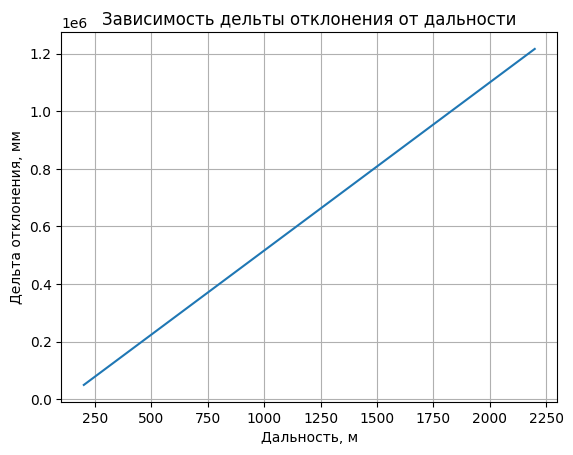

In [7]:
plt.plot(x_array, y_array*1000)
plt.grid()
plt.title("Зависимость дельты отклонения от дальности")
plt.ylabel("Дельта отклонения, мм")
plt.xlabel("Дальность, м")

2. Модель брони танка

In [8]:
missile_penetration = 350

In [9]:
def make_rect(x, y, width, height, thickness, color, ax, armors, alpha=0.5, rotate=0, obstacle = False):
    color = 'green' if missile_penetration > thickness else 'red'
    if thickness == 0:
        color = color
    rect = patches.Rectangle((x, y), width, height, linewidth=1, edgecolor='r', facecolor=color, alpha=alpha)
    
    rx, ry = rect.get_xy()
    cx = rx + rect.get_width()/2.0
    cy = ry + rect.get_height()/2.0
    
    if rotate != 0:
        t2 = mpl.transforms.Affine2D().rotate_deg_around(cx, cy, rotate) + ax.transData
        rect.set_transform(t2)
    
    ax.add_patch(rect)
    if obstacle == False:
        ax.annotate(f'{thickness}', (cx, cy), color='white', weight='bold', fontsize=10, ha='center', va='center')
    
    hit = 1 if color == 'green' else 0
    new_dict = dict()
    armors.append({"x_bottom": x, "y_bottom": y, "x_top": x+width, "y_top": y+height, "hit": hit, "thickness": thickness})

In [10]:
def tank_dots(x, y, step=100):
    
    tank_front_dots_x = np.arange(0, x, step)
    tank_front_dots_y = np.arange(0, y, step)

    x_array_dots = []
    y_array_dots = []

    for x_dot in tank_front_dots_x:
        for y_dot in tank_front_dots_y:
            x_array_dots.append(x_dot)
            y_array_dots.append(y_dot)
    
    return [x_array_dots, y_array_dots]

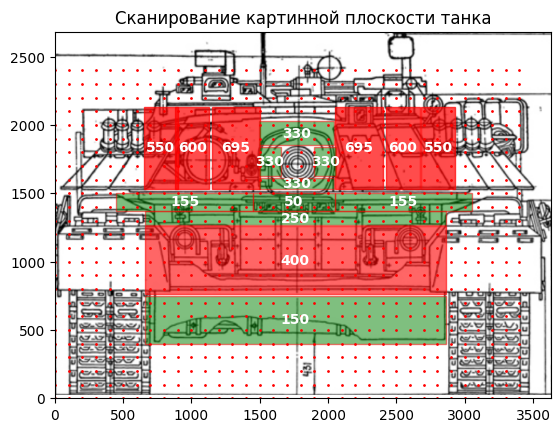

In [11]:
img = plt.imread("tank_pered.png")
fig, ax = plt.subplots()

ax.imshow(img, extent=[0, 3630, 0, 2682])

front_armors = []

# Корпус

make_rect(660, 400, 2200, 350, 150, 'green', ax, front_armors)
make_rect(660, 760, 2200, 500, 400, 'red', ax, front_armors, 0.6)
make_rect(660, 1265, 2200, 105, 250, 'red', ax, front_armors)

make_rect(450, 1370, 1000, 135, 155, 'red', ax, front_armors)
make_rect(2050, 1370, 1000, 135, 155, 'red', ax, front_armors)

make_rect(1450, 1370, 600, 135, 50, 'red', ax, front_armors)

# Башня

make_rect(1150, 1535, 350, 600, 695, 'red', ax, front_armors, 0.7)
make_rect(880, 1535, 250, 600, 600, 'red', ax, front_armors, 0.7)
make_rect(650, 1535, 250, 600, 550, 'red', ax, front_armors, 0.7)


make_rect(2050, 1535, 350, 600, 695, 'red', ax, front_armors, 0.7)
make_rect(2420, 1535, 250, 600, 600, 'red', ax, front_armors, 0.7)
make_rect(2680, 1535, 250, 600, 550, 'red', ax, front_armors, 0.7)

# Маска орудия

make_rect(1495, 1535, 550, 80, 330, 'green', ax, front_armors)
make_rect(1495, 1850, 550, 180, 330, 'green', ax, front_armors)

make_rect(1495, 1630, 160, 210, 330, 'green', ax, front_armors)
make_rect(1900, 1630, 160, 210, 330, 'green', ax, front_armors)

# Сканирование

[x_dots, y_dots] = tank_dots(3500, 2500)

ax.scatter(x_dots, y_dots, s=1, color='red')
ax.set_title('Сканирование картинной плоскости танка')

plt.show()

In [12]:
def armor_table(armors):
    df = pd.DataFrame(data={'x_bot': [], 'x_top': [], 'y_bot': [], 'y_top': [], 'Толщина': []})
    for i in range(len(armors)):
        df.loc[i] = [int(armors[i]['x_bottom']), 
                     int(armors[i]['x_top']), 
                     int(armors[i]['y_bottom']),
                     int(armors[i]['x_top']),
                     int(armors[i]['thickness'])]
    return df
    
armor_table(front_armors)

,x_bot,x_top,y_bot,y_top,Толщина
0,660,2860,400,2860,150
1,660,2860,760,2860,400
2,660,2860,1265,2860,250
3,450,1450,1370,1450,155
4,2050,3050,1370,3050,155
5,1450,2050,1370,2050,50
6,1150,1500,1535,1500,695
7,880,1130,1535,1130,600
8,650,900,1535,900,550
9,2050,2400,1535,2400,695


In [13]:
distance = 2000
standard_deviation = extrapolation_(distance)
print(standard_deviation)

1100.0


Version 2.0

In [14]:



start_time = time.time()
probability_array, probabilities_local = [], []

for i in range(len(x_dots)):
    probability_local_array = []
    hit, j = 0, -1

    while (True):
        j += 1

        x_dot = np.random.normal(x_dots[i], standard_deviation)
        y_dot = np.random.normal(y_dots[i], standard_deviation)

        for armor in front_armors:
            if x_dot < armor['x_top'] \
                and x_dot > armor['x_bottom'] \
                and y_dot < armor['y_top'] \
                and y_dot > armor['y_bottom']:

                if missile_penetration > armor['thickness']:
                    hit += 1
                    break

        probability_local_array.append(hit / (j+1))
        if len(probability_local_array) > 500:
            if abs(probability_local_array[-1] - probability_local_array[-2]) < 0.0001:
                break


    probabilities_local.append(probability_local_array)
    probability_array.append(hit / len(probability_local_array))

print("--- %s seconds ---" % (time.time() - start_time))

--- 12.60347056388855 seconds ---


In [15]:
probability_array

[0.041916167664670656,
 0.041916167664670656,
 0.03792415169660679,
 0.0631911532385466,
 0.06158833063209076,
 0.06230031948881789,
 0.06471494607087827,
 0.04590818363273453,
 0.0564373897707231,
 0.06230031948881789,
 0.06696428571428571,
 0.0564373897707231,
 0.050880626223091974,
 0.050880626223091974,
 0.052830188679245285,
 0.0499001996007984,
 0.04590818363273453,
 0.05182341650671785,
 0.05555555555555555,
 0.0499001996007984,
 0.029940119760479042,
 0.03792415169660679,
 0.04790419161676647,
 0.03592814371257485,
 0.0499001996007984,
 0.04790419161676647,
 0.0499001996007984,
 0.0499001996007984,
 0.0546448087431694,
 0.053703703703703705,
 0.07202216066481995,
 0.07270233196159122,
 0.059900166389351084,
 0.059900166389351084,
 0.08769931662870159,
 0.06230031948881789,
 0.05555555555555555,
 0.06230031948881789,
 0.0546448087431694,
 0.069164265129683,
 0.059900166389351084,
 0.07202216066481995,
 0.033932135728542916,
 0.06230031948881789,
 0.052830188679245285,
 0.0379241

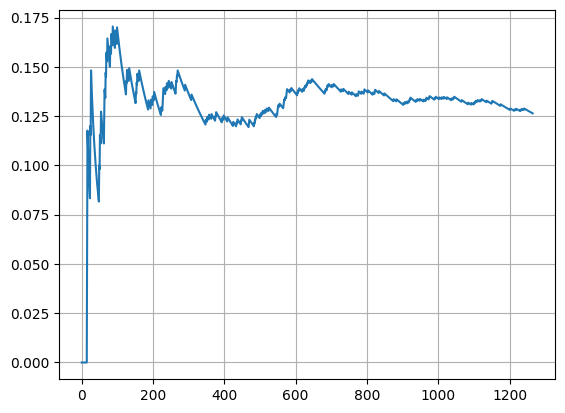

In [16]:
fig, ax = plt.subplots()
ax.plot(np.arange(len(probabilities_local[355])), probabilities_local[355])
plt.grid()

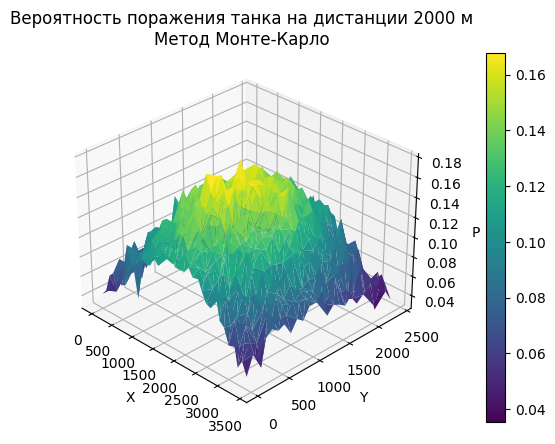

In [17]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

X = x_dots
Y = y_dots
Z = probability_array

surf = ax.plot_trisurf(X, Y, Z, cmap='viridis', edgecolor='none')

plt.colorbar(surf)
plt.subplots_adjust(right=2)

ax.set_title(f'Вероятность поражения танка на дистанции {distance} м\nМетод Монте-Карло')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('P')

ax.view_init(30, -45)

# ax.set_zticks(np.arange(0, 0.8, 0.1))

Модель генерации ландшафта

In [18]:
TREE_NAME = 'tree'
ROCK_NAME = 'rock'

TREE_COLOR = '#54E22A'
ROCK_COLOR = '#219FF7'

TREE_DIAMETER_MEAN = 0.25
TREE_DIAMETER_STD = 0.1

TREE_HEIGHT_MEAN = 15
TREE_HEIGHT_STD = 5

ROCK_DIAMETER_MEAN = 0.25
ROCK_DIAMETER_STD = 0.1

ROCK_HEIGHT_MEAN = 0.4
ROCK_HEIGHT_STD = 0.3

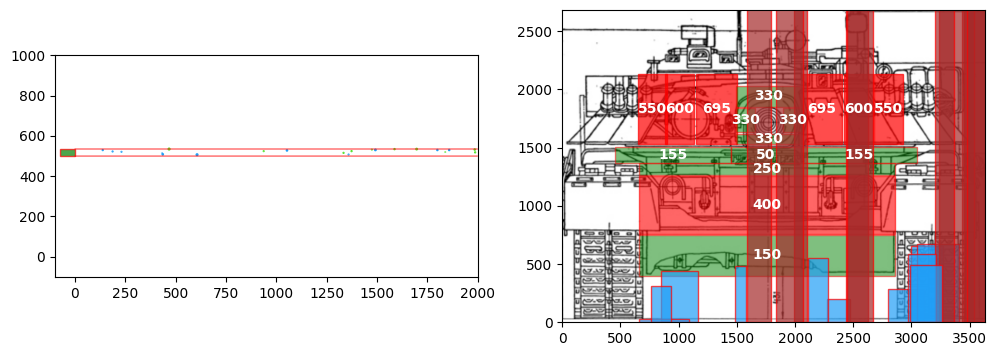

In [19]:
num = 21
img = plt.imread("tank_pered.png")

obstacles = []
for i in range(num):
    new_obstacle = {}

    new_obstacle['name'] = np.random.choice([TREE_NAME, ROCK_NAME])
    new_obstacle['x'] = np.random.uniform(0, 2000)
    new_obstacle['y'] = np.random.uniform(500, 535)
    
    if new_obstacle['name'] == TREE_NAME:
        new_obstacle['color'] = TREE_COLOR
        new_obstacle['diameter'] = np.random.normal(TREE_DIAMETER_MEAN, TREE_DIAMETER_STD)*10
        new_obstacle['height'] = np.random.normal(TREE_HEIGHT_MEAN, TREE_HEIGHT_STD)
    else:
        new_obstacle['color'] = ROCK_COLOR
        new_obstacle['diameter'] = np.random.normal(ROCK_DIAMETER_MEAN, ROCK_DIAMETER_STD)*10
        new_obstacle['height'] = np.random.normal(ROCK_HEIGHT_MEAN, ROCK_HEIGHT_STD)
    
    obstacles.append(new_obstacle)
        
    
# sample_x = np.random.uniform(0, 1000, num) 
# sample_y = np.random.uniform(0, 1000, num)

x_obstacle = [obstacle['x'] for obstacle in obstacles]
y_obstacle = [obstacle['y'] for obstacle in obstacles]
sizes = np.array([obstacle['diameter'] for obstacle in obstacles])
colors = np.array([obstacle['color'] for obstacle in obstacles])

fig, axs = plt.subplots(1, 2)
tank = []
make_rect(-75, 500, 75, 35, 0, 'red', axs[0], tank, 0.7, 0, True)

# ax.scatter(x_obstacale, y_obstacale, s=sizes*50, c=colors)
for i in range(len(x_obstacle)):
    make_circle(x_obstacle[i], y_obstacle[i], sizes[i], colors[i], axs[0])

axs[0].set_xlim(-100, 2000)
axs[0].set_ylim(-100, 1000)

axs[0].plot(np.arange(0, 2000, 1), [500 for i in range(0, 2000)], color='red', linewidth=0.6)
axs[0].plot(np.arange(0, 2000, 1), [535 for i in range(0, 2000)], color='red', linewidth=0.6)
# ax.set_xlim(250, 1000)
# ax.set_ylim(250, 1000)



fig.set_figheight(12)
fig.set_figwidth(12)

axs[0].set_aspect('equal', adjustable='box')
axs[1].imshow(img, extent=[0, 3630, 0, 2682])
front_armors = []

# Корпус

make_rect(660, 400, 2200, 350, 150, 'green', axs[1], front_armors)
make_rect(660, 760, 2200, 500, 400, 'red', axs[1], front_armors, 0.6)
make_rect(660, 1265, 2200, 105, 250, 'red', axs[1], front_armors)

make_rect(450, 1370, 1000, 135, 155, 'red', axs[1], front_armors)
make_rect(2050, 1370, 1000, 135, 155, 'red', axs[1], front_armors)

make_rect(1450, 1370, 600, 135, 50, 'red', axs[1], front_armors)

# Башня

make_rect(1150, 1535, 350, 600, 695, 'red', axs[1], front_armors, 0.7)
make_rect(880, 1535, 250, 600, 600, 'red', axs[1], front_armors, 0.7)
make_rect(650, 1535, 250, 600, 550, 'red', axs[1], front_armors, 0.7)


make_rect(2050, 1535, 350, 600, 695, 'red', axs[1], front_armors, 0.7)
make_rect(2420, 1535, 250, 600, 600, 'red', axs[1], front_armors, 0.7)
make_rect(2680, 1535, 250, 600, 550, 'red', axs[1], front_armors, 0.7)

# Маска орудия

make_rect(1495, 1535, 550, 80, 330, 'green', axs[1], front_armors)
make_rect(1495, 1850, 550, 180, 330, 'green', axs[1], front_armors)

make_rect(1495, 1630, 160, 210, 330, 'green', axs[1], front_armors)
make_rect(1900, 1630, 160, 210, 330, 'green', axs[1], front_armors)

obs = []

for obstacle in obstacles:
    if obstacle['x'] > 0 \
        and obstacle['x'] < distance \
        and obstacle['y'] > 500 \
        and obstacle['y'] < 535:
        make_obstacle(normalize_width(obstacle['y'], 500, 535) * 3500, 0, obstacle['diameter'] * 100, obstacle['height'] * 1000, obstacle['name'], axs[1], obs)


plt.show()

## Модель генерации ландшафта

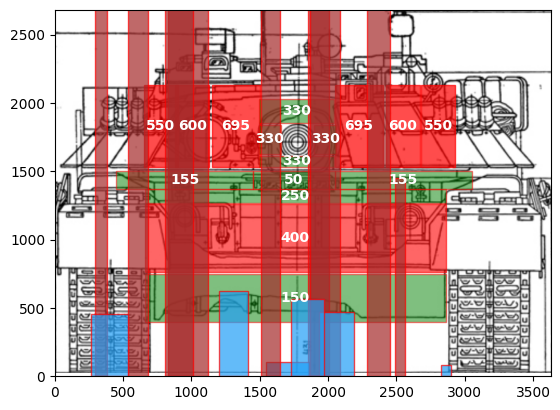

In [20]:
num = 600
img = plt.imread("tank_pered.png")

obstacles = []
for i in range(num):
    new_obstacle = {}

    new_obstacle['name'] = np.random.choice([TREE_NAME, ROCK_NAME])
    new_obstacle['x'] = np.random.uniform(0, 2000)
    new_obstacle['y'] = np.random.uniform(0, 2000)
    
    if new_obstacle['name'] == TREE_NAME:
        new_obstacle['color'] = TREE_COLOR
        new_obstacle['diameter'] = np.random.normal(TREE_DIAMETER_MEAN, TREE_DIAMETER_STD)
        new_obstacle['height'] = np.random.normal(TREE_HEIGHT_MEAN, TREE_HEIGHT_STD)
    else:
        new_obstacle['color'] = ROCK_COLOR
        new_obstacle['diameter'] = np.random.normal(ROCK_DIAMETER_MEAN, ROCK_DIAMETER_STD)
        new_obstacle['height'] = np.random.normal(ROCK_HEIGHT_MEAN, ROCK_HEIGHT_STD)
    
    obstacles.append(new_obstacle)
    
    
    
fig, ax = plt.subplots()
ax.imshow(img, extent=[0, 3630, 0, 2682])

front_armors = []

# Корпус

make_rect(660, 400, 2200, 350, 150, 'green', ax, front_armors)
make_rect(660, 760, 2200, 500, 400, 'red', ax, front_armors, 0.6)
make_rect(660, 1265, 2200, 105, 250, 'red', ax, front_armors)

make_rect(450, 1370, 1000, 135, 155, 'red', ax, front_armors)
make_rect(2050, 1370, 1000, 135, 155, 'red', ax, front_armors)

make_rect(1450, 1370, 600, 135, 50, 'red', ax, front_armors)

# Башня

make_rect(1150, 1535, 350, 600, 695, 'red', ax, front_armors, 0.7)
make_rect(880, 1535, 250, 600, 600, 'red', ax, front_armors, 0.7)
make_rect(650, 1535, 250, 600, 550, 'red', ax, front_armors, 0.7)


make_rect(2050, 1535, 350, 600, 695, 'red', ax, front_armors, 0.7)
make_rect(2420, 1535, 250, 600, 600, 'red', ax, front_armors, 0.7)
make_rect(2680, 1535, 250, 600, 550, 'red', ax, front_armors, 0.7)

# Маска орудия

make_rect(1495, 1535, 550, 80, 330, 'green', ax, front_armors)
make_rect(1495, 1850, 550, 180, 330, 'green', ax, front_armors)

make_rect(1495, 1630, 160, 210, 330, 'green', ax, front_armors)
make_rect(1900, 1630, 160, 210, 330, 'green', ax, front_armors)




# Препятствия

obstacles_array = []

for obstacle in obstacles:
    if obstacle['x'] > 235 \
        and obstacle['x'] < 2000 \
        and obstacle['y'] > 500 \
        and obstacle['y'] < 535:
        make_obstacle(normalize_width(obstacle['y'], 500, 535) * 3500, 0, obstacle['diameter'] * 1000, obstacle['height'] * 1000, obstacle['name'], ax, obstacles_array)




In [18]:
obstacles_array

[{'x_bottom': 500, 'y_bottom': 500, 'x_top': 3000, 'y_top': 2500, 'hit': 0}]

## Итоговая модель

In [46]:
start_time = time.time()

num = 7
summary_probability = np.array([0])
summary_array = []
iter_num = 50
times = []

for i in range(iter_num):
    

    obstacles = []
    for i in range(num):
        new_obstacle = {}

        new_obstacle['name'] = np.random.choice([TREE_NAME, ROCK_NAME])
        new_obstacle['x'] = np.random.uniform(0, 2000)
        new_obstacle['y'] = np.random.uniform(500, 535)

        if new_obstacle['name'] == TREE_NAME:
            new_obstacle['color'] = TREE_COLOR
            new_obstacle['diameter'] = np.random.normal(TREE_DIAMETER_MEAN, TREE_DIAMETER_STD)
            new_obstacle['height'] = np.random.normal(TREE_HEIGHT_MEAN, TREE_HEIGHT_STD)
        else:
            new_obstacle['color'] = ROCK_COLOR
            new_obstacle['diameter'] = np.random.normal(ROCK_DIAMETER_MEAN, ROCK_DIAMETER_STD)
            new_obstacle['height'] = np.random.normal(ROCK_HEIGHT_MEAN, ROCK_HEIGHT_STD)

        obstacles.append(new_obstacle)
        
    obstacles_array = []

    for obstacle in obstacles:
        if obstacle['x'] > 0 \
            and obstacle['x'] < distance \
            and obstacle['y'] > 500 \
            and obstacle['y'] < 535:
            make_obstacle(normalize_width(obstacle['y'], 500, 535) * 3500, 0, obstacle['diameter'] * 1000, obstacle['height'] * 1000, obstacle['name'], ax, obstacles_array)


    probability_array, probabilities_local = [], []

    for i in range(len(x_dots)):
        probability_local_array = []
        hit, j = 0, -1

        while (True):
            j += 1
            miss = False

            x_dot = np.random.normal(x_dots[i], standard_deviation)
            y_dot = np.random.normal(y_dots[i], standard_deviation)

            for obstacle in obstacles_array:
                if x_dot < obstacle['x_top'] \
                    and x_dot > obstacle['x_bottom'] \
                    and y_dot < obstacle['y_top'] \
                    and y_dot > obstacle['y_bottom']:

                    miss = True
                    break


            if miss != True:

                for armor in front_armors:
                    if x_dot < armor['x_top'] \
                        and x_dot > armor['x_bottom'] \
                        and y_dot < armor['y_top'] \
                        and y_dot > armor['y_bottom']:

                        if missile_penetration > armor['thickness']:
                            hit += 1
                            break

            probability_local_array.append(hit / (j+1))
            if len(probability_local_array) > 500:
                if abs(probability_local_array[-1] - probability_local_array[-2]) < 0.0001:
                    break


        probabilities_local.append(probability_local_array)
        probability_array.append(hit / len(probability_local_array))
        
    summary_array.append(probability_array)
    summary_probability = np.add(summary_probability, probability_array)
    times.append(time.time() - start_time)
    
print("--- %s seconds ---" % (time.time() - start_time))

--- 594.4198915958405 seconds ---


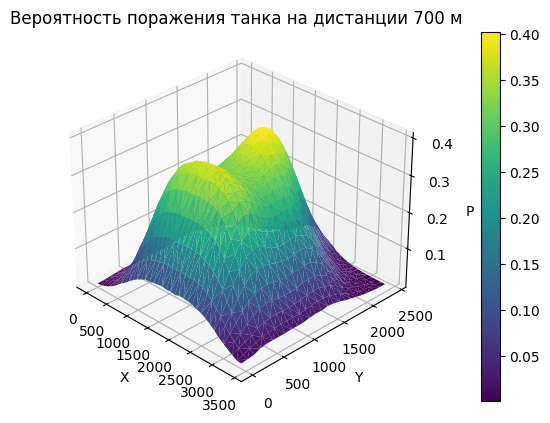

In [47]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

X = x_dots
Y = y_dots
Z = np.add.reduce(summary_array) / iter_num
surf = ax.plot_trisurf(X, Y, Z, cmap='viridis', edgecolor='none')

plt.colorbar(surf)
plt.subplots_adjust(right=2)

ax.set_title(f'Вероятность поражения танка на дистанции {distance} м')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('P')

ax.view_init(30, -45)



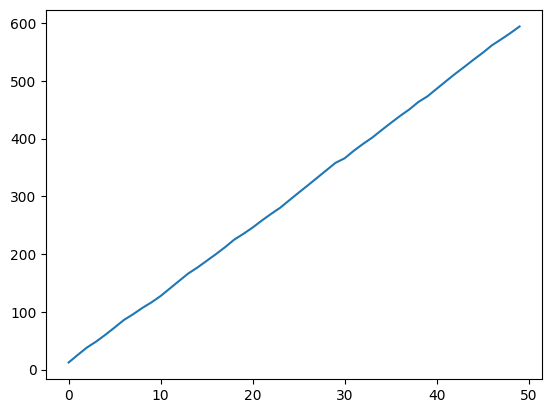

In [48]:
plt.plot(np.arange(50), times)

In [51]:

def compute_monte_carlo(x_dots, y_dots, armors, density, distance, width, iter_num=25):
    
    start_time = time.time()

    # density - количество деревьев на 1000 м2   
    
    num = int((((width / 1000) * 2000) / 1000) * density)
    print(num)
    summary_array = []
    iter_num = iter_num


    for t in range(iter_num):


        obstacles = []
        for i in range(num):
            new_obstacle = {}

            new_obstacle['name'] = choice([TREE_NAME, ROCK_NAME])
            new_obstacle['x'] = uniform(0, 2000)
            new_obstacle['y'] = uniform(500, 500 + (width / 100))

            if new_obstacle['name'] == TREE_NAME:
                new_obstacle['color'] = TREE_COLOR
                new_obstacle['diameter'] = normal(TREE_DIAMETER_MEAN, TREE_DIAMETER_STD)
                new_obstacle['height'] = normal(TREE_HEIGHT_MEAN, TREE_HEIGHT_STD)
            else:
                new_obstacle['color'] = ROCK_COLOR
                new_obstacle['diameter'] = normal(ROCK_DIAMETER_MEAN, ROCK_DIAMETER_STD)
                new_obstacle['height'] = normal(ROCK_HEIGHT_MEAN, ROCK_HEIGHT_STD)

            obstacles.append(new_obstacle)

        obstacles_array = []

        for obstacle in obstacles:
            if obstacle['x'] > 0 \
                and obstacle['x'] < distance \
                and obstacle['y'] > 500 \
                and obstacle['y'] < (500 + (width / 100)):
                obstacles_array.append({"x_bottom": normalize_width(obstacle['y'], 500, (500 + (width / 100))) * width, \
                                        "y_bottom": 0, \
                                        "x_top": normalize_width(obstacle['y'], 500, (500 + (width / 100))) * width+obstacle['diameter'] * 1000, \
                                        "y_top": obstacle['height'] * 1000, \
                                        "hit": 0})
#                 make_obstacle(normalize_width(obstacle['y'], 500, (500 + (width / 100))) * width, 0, obstacle['diameter'] * 1000, obstacle['height'] * 1000, obstacle['name'], ax, obstacles_array)


        probability_array, probabilities_local = [], []

        for i in range(len(x_dots)):
            probability_local_array = []
            hit, j = 0, -1

            while (True):
                j += 1
                miss = False

                x_dot = normal(x_dots[i], standard_deviation)
                y_dot = normal(y_dots[i], standard_deviation)

                for obstacle in obstacles_array:
                    if x_dot < obstacle['x_top'] \
                        and x_dot > obstacle['x_bottom'] \
                        and y_dot < obstacle['y_top'] \
                        and y_dot > obstacle['y_bottom']:

                        miss = True
                        break


                if miss != True:

                    for armor in armors:
                        if x_dot < armor['x_top'] \
                            and x_dot > armor['x_bottom'] \
                            and y_dot < armor['y_top'] \
                            and y_dot > armor['y_bottom']:

                            if missile_penetration > armor['thickness']:
                                hit += 1
                                break

                probability_local_array.append(hit / (j+1))
                if len(probability_local_array) > 500:
                    if abs(probability_local_array[-1] - probability_local_array[-2]) < 0.0001:
                        break


            probabilities_local.append(probability_local_array)
            probability_array.append(hit / len(probability_local_array))

        summary_array.append(probability_array)

        print(f'{(t / iter_num) * 100}% done - {time.time() - start_time}')

    print("--- %s seconds ---" % (time.time() - start_time))
    return summary_array

In [52]:
def plot_monte_carlo(x, y, z, iter_num):
    fig, ax = plt.subplots(subplot_kw={"projection": "3d"})

    X = x
    Y = y
    Z = np.add.reduce(z) / iter_num
    surf = ax.plot_trisurf(X, Y, Z, cmap='viridis', edgecolor='none')

    plt.colorbar(surf)
    plt.subplots_adjust(right=2)

    ax.set_title(f'Вероятность поражения танка на дистанции {distance} м\nПлотность {density} препятств. на м2')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('P')

    ax.set_zticks(np.arange(0, 0.9, 0.1))
    ax.view_init(30, -45)


In [53]:
distance = 1700
density = 3

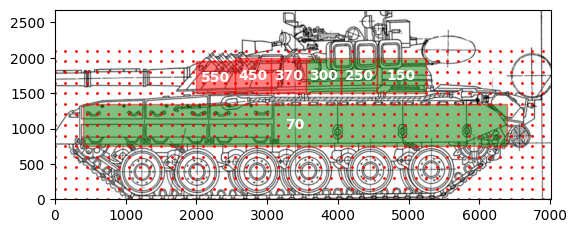

In [54]:
img = plt.imread("tank_bok_short.png")
fig, ax = plt.subplots()
x = range(300)
ax.imshow(img, extent=[0, 7012, 0, 2682])

side_armors = []


# Корпус
make_rect(395, 750, 6000, 600, 70, 'green', ax, side_armors)

# Башня
make_rect(2000, 1500, 550, 450, 550, 'red', ax, side_armors)
make_rect(2550, 1500, 500, 500, 450, 'red', ax, side_armors)
make_rect(3050, 1500, 500, 500, 370, 'green', ax, side_armors)
make_rect(3550, 1500, 500, 500, 300, 'green', ax, side_armors)
make_rect(4050, 1500, 500, 500, 250, 'green', ax, side_armors)
make_rect(4550, 1500, 700, 500, 150, 'green', ax, side_armors)

# Сканирование

[x_side_dots, y_side_dots] = tank_dots(7000, 2200, 150)
ax.scatter(x_side_dots, y_side_dots, s=1, color='red')

plt.show()


In [55]:
side_prob = compute_monte_carlo(x_side_dots, y_side_dots, side_armors, density, distance, 7000, 20)

42
0.0% done - 6.413116693496704
5.0% done - 14.070394277572632
10.0% done - 23.793222665786743
15.0% done - 31.309393167495728
20.0% done - 38.93123722076416
25.0% done - 46.689077377319336
30.0% done - 54.413278341293335
35.0% done - 61.260611057281494
40.0% done - 70.87583661079407
45.0% done - 77.9027452468872
50.0% done - 89.3896746635437
55.00000000000001% done - 97.59088683128357
60.0% done - 111.60570549964905
65.0% done - 122.08805298805237
70.0% done - 132.01340699195862
75.0% done - 142.28022837638855
80.0% done - 151.73069667816162
85.0% done - 159.40828204154968
90.0% done - 169.0848195552826
95.0% done - 177.98811674118042
--- 177.98811674118042 seconds ---


In [ ]:
plot_monte_carlo(x_side_dots, y_side_dots, side_prob, 80)

In [209]:
len(x_side_dots)

705

Text(0.5, 0, 'X')

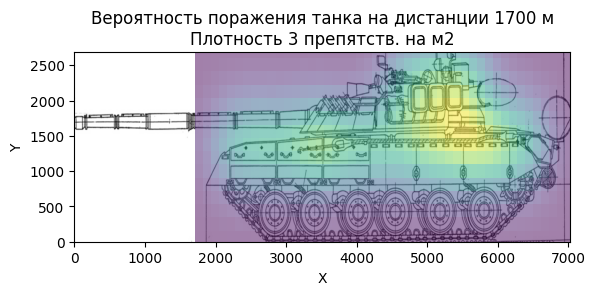

In [216]:
len(x_side_dots)
s = np.array(np.add.reduce(side_prob) / 80).reshape(47, 15)

base = ax.transData
rot = mtransforms.Affine2D().scale(0.4, 2).translate(-1300, -7000).rotate_deg(90)



img = plt.imread("tank_bok.png")
fig, ax = plt.subplots()
img1 = ax.imshow(img, extent=[0, 7030, 0, 2682])
img2 = ax.imshow(s, cmap='viridis', alpha=0.5, extent=[0, 7030, 0, 2682])

img2.set_transform(rot + base)

ax.set_title(f'Вероятность поражения танка на дистанции {distance} м\nПлотность {density} препятств. на м2')
ax.set_ylabel('Y')
ax.set_xlabel('X')


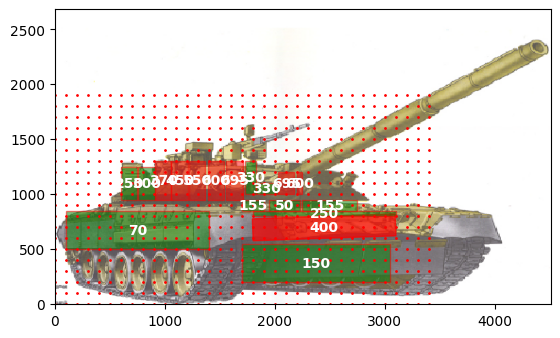

In [217]:
img = plt.imread("tank_ugol.png")
fig, ax = plt.subplots()
ax.imshow(img, extent=[0, 4512, 0, 2682])

angle_armors = []

# Корпус
make_rect(100, 500, 1300, 350, 70, 'green', ax, angle_armors)
make_rect(1700, 200, 1350, 350, 150, 'green', ax, angle_armors)
make_rect(1800, 600, 1300, 200, 400, 'green', ax, angle_armors, 0.7, 2)
make_rect(1800, 800, 1300, 50, 250, 'green', ax, angle_armors)

make_rect(1700, 850, 200, 100, 155, 'green', ax, angle_armors)
make_rect(2250, 850, 500, 100, 155, 'green', ax, angle_armors)

make_rect(1950, 850, 280, 100, 50, 'green', ax, angle_armors)


# Башня

make_rect(1730, 1000, 100, 300, 330, 'green', ax, angle_armors)
make_rect(1830, 1000, 200, 100, 330, 'green', ax, angle_armors)

make_rect(2200, 1000, 50, 200, 600, 'green', ax, angle_armors)
make_rect(2030, 1000, 150, 200, 695, 'green', ax, angle_armors)
make_rect(1560, 950, 150, 350, 695, 'green', ax, angle_armors)
make_rect(1390, 950, 150, 350, 600, 'green', ax, angle_armors)
make_rect(1220, 950, 150, 350, 550, 'green', ax, angle_armors)

make_rect(1060, 950, 150, 350, 450, 'green', ax, angle_armors)
make_rect(910, 950, 150, 350, 370, 'green', ax, angle_armors)
make_rect(760, 950, 150, 300, 300, 'green', ax, angle_armors)
make_rect(600, 950, 150, 300, 250, 'green', ax, angle_armors)

[x_angle_dots, y_angle_dots] = tank_dots(3500, 2000)
ax.scatter(x_angle_dots, y_angle_dots, s=1, color='red')

In [61]:
len(x_angle_dots)

700

In [284]:
distance = 700
density = 6

In [285]:
angle_prob = compute_monte_carlo(x_angle_dots, y_angle_dots, angle_armors, 1, distance, 3300, 20)

6
0.0% done - 13.023178577423096
5.0% done - 27.21460199356079
10.0% done - 39.55580735206604
15.0% done - 53.13617992401123
20.0% done - 66.28669619560242
25.0% done - 79.45369482040405
30.0% done - 93.98748016357422
35.0% done - 107.5383358001709
40.0% done - 119.6244285106659
45.0% done - 133.08303022384644
50.0% done - 147.02492761611938
55.00000000000001% done - 160.28461480140686
60.0% done - 173.2564046382904
65.0% done - 185.33255529403687
70.0% done - 197.02282238006592
75.0% done - 209.3930401802063
80.0% done - 222.09796714782715
85.0% done - 235.00848293304443
90.0% done - 248.72612738609314
95.0% done - 262.0544412136078
--- 262.0544412136078 seconds ---


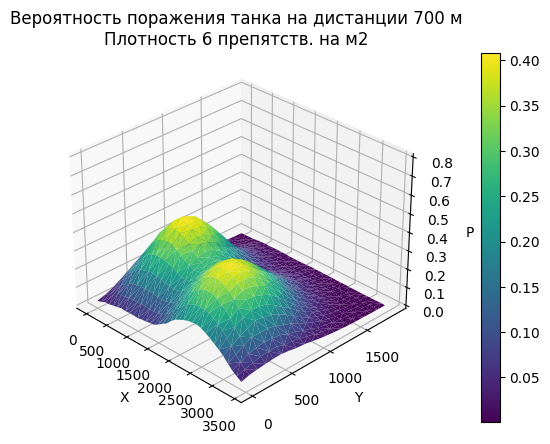

In [287]:
plot_monte_carlo(x_angle_dots, y_angle_dots, angle_prob, 20)

Text(0.5, 0, 'X')

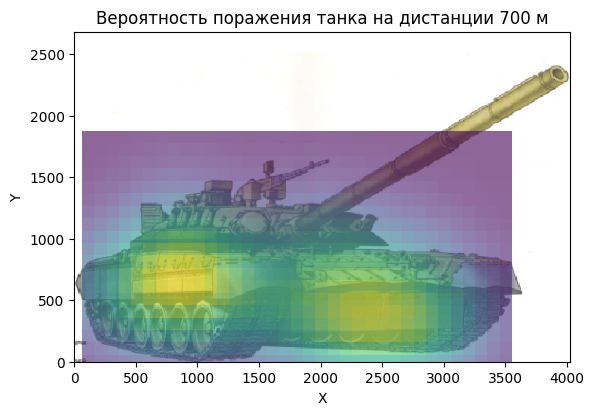

In [283]:
len(x_angle_dots)
s = np.array(np.add.reduce(angle_prob) / 60).reshape(35, 20)

base = ax.transData
rot = mtransforms.Affine2D().scale(0.5, 1.3).translate(-300, -3500).rotate_deg(90)



img = plt.imread("tank_ugol.png")
fig, ax = plt.subplots()
img1 = ax.imshow(img, extent=[0, 4030, 0, 2682])
img2 = ax.imshow(s, cmap='viridis', alpha=0.6, extent=[0, 4030, 0, 2682])

img2.set_transform(rot + base)

ax.set_title(f'Вероятность поражения танка на дистанции {distance} м')
ax.set_ylabel('Y')
ax.set_xlabel('X')

In [86]:
front_prob = compute_monte_carlo(x_dots, y_dots, front_armors, density, distance, 3500, 20)

21
0.0% done - 6.283806085586548
5.0% done - 11.795231819152832
10.0% done - 17.30762243270874
15.0% done - 22.013885974884033
20.0% done - 28.910521030426025
25.0% done - 37.66077518463135
30.0% done - 46.12527942657471
35.0% done - 53.079301834106445
40.0% done - 58.85663366317749
45.0% done - 64.84053754806519
50.0% done - 70.03527164459229
55.00000000000001% done - 77.37231802940369
60.0% done - 85.18020462989807
65.0% done - 92.66754412651062
70.0% done - 98.37293982505798
75.0% done - 102.88465714454651
80.0% done - 111.7445547580719
85.0% done - 119.77091956138611
90.0% done - 124.60470843315125
95.0% done - 129.663241147995
--- 129.663241147995 seconds ---


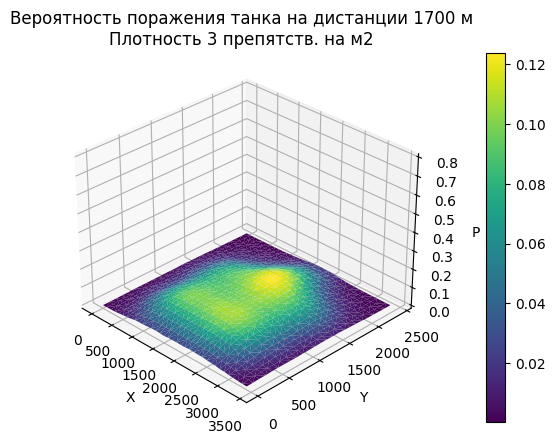

In [92]:
plot_monte_carlo(x_dots, y_dots, front_prob, 35)

Text(0.5, 0, 'X')

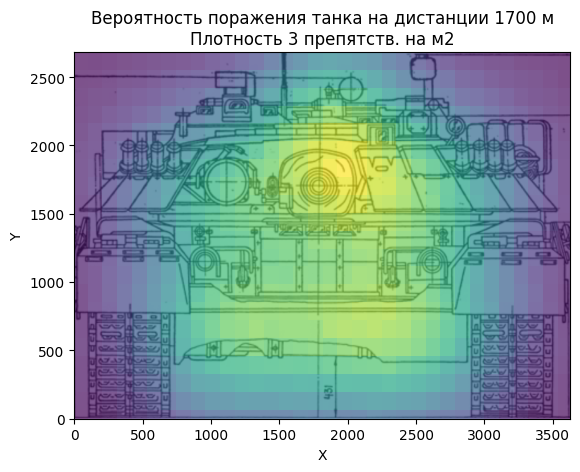

In [93]:
s = np.array(np.add.reduce(front_prob) / 30).reshape(35, 25)

base = ax.transData
rot = mtransforms.Affine2D().scale(0.9, 1.4).translate(-200, -3600).rotate_deg(90)



img = plt.imread("pered.png")
fig, ax = plt.subplots()
img1 = ax.imshow(img, extent=[0, 3630, 0, 2682])
img2 = ax.imshow(s, cmap='viridis', alpha=0.7, extent=[0, 3630, 0, 2682])

img2.set_transform(rot + base)

ax.set_title(f'Вероятность поражения танка на дистанции {distance} м\nПлотность {density} препятств. на м2')
ax.set_ylabel('Y')
ax.set_xlabel('X')